# Import

In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../garfield/')
from Genetic_algorithm import *
from Minimization_functions import *
from Resonator_formula import *
from framework import GeneticAlgorithm

import pyfde

## Example with the simulated PS kicker KFA21 impedance and wake function

In [6]:
#Studied component, can be set to dipx, dipy, quadx or quady
component = "quadx"

#Number of resonators
Nres = 4 # can be changed to see what happens

impedance_file = pd.read_csv(
    "PE.KFA21_CST_2015_10GHz.imp",
    sep="\s+",
    index_col=False,
    names=[
        "f",
        "Re(Zdipx)",
        "Im(Zdipx)",
        "Re(Zdipy)",
        "Im(Zdipy)",
        "Re(Zquadx)",
        "Im(Zquadx)",
        "Re(Zquady)",
        "Im(Zquady)",
    ],
    header=0,
)

frequency_data = impedance_file['f'].to_numpy() #frequencies in Hz
impedance_data = impedance_file[f'Re(Z{component})'].to_numpy() + \
                 1j*impedance_file[f'Im(Z{component})'].to_numpy()

wake_data = pd.read_csv(
    'PE.KFA21_CST_2015_10GHz.wake', 
    sep='\s+', 
    index_col=False, 
    names=[
        "t", 
        "Wdipx", 
        "Wdipy",
        "Wquadx",
        "Wquady"
    ]
)

wake_data = wake_data.loc[wake_data['t'] >= 0]
time_data = wake_data[f't'].to_numpy()
wake_data = wake_data[f'W{component}'].to_numpy()

""" Bounds on resonators parameters, it's possible to manually set them as well.
Bounds have this format [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].
ParameterBounds allows us to manually add a resonator with desired parameters """
bounds = [(-7e5, 7e5), (0, 20), (1e3, 1e10)]
parameterBounds = Nres * bounds

## Let us run the genetic algorithm using three different solvers: scipy, pyfde, pyfde_jade. The scipy solver is the fastest and yields satisfactory results.
## The pyfde solver yields similar results to the scipy one but tends to be slower.
## The pyfde_jade solver is an adaptative genetic algorithm, meaning it does not require the mutation constant and crossover rate as they will be adaptively changed during run time. It allows to find the best suited parameters for the problem considered. As a result, it gives the best fit at the expense of a costy convergence. Most of the times, the algorithm is stopped after reaching the maximum number of iterations.
## The tolerance is left quite high (e.g. 1%) as an accurate solution is not needed. A second optimization takes place later with a minimization algorithm.

In [8]:
%%time
GA_model_scipy = GeneticAlgorithm(frequency_data, 
                                  impedance_data, 
                                  time_data, wake_data, 
                                  N_resonators=Nres,
                                  parameterBounds=parameterBounds,
                                  minimizationFunction=sumOfSquaredError,
                                  fitFunction=n_Resonator_transverse_imp
                                 )

GA_model_scipy.run_geneticAlgorithm(maxiter=3000, 
                                    popsize=25, 
                                    tol=0.01,
                                    mutation=(0.1, 0.6), 
                                    crossover_rate=0.8
                                   )

 Convergence to optimal solution : [####################] 100%
----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |       -5.77e+03        |       8.19       |    2.964e+09     
    2     |       -3.28e+04        |       0.43       |    1.128e+09     
    3     |       -3.04e+05        |      13.10       |    1.919e+09     
    4     |        2.94e+05        |      13.47       |    1.918e+09     
----------------------------------------------------------------------
CPU times: user 1.29 s, sys: 578 ms, total: 1.87 s
Wall time: 1.91 s


In [9]:
%%time
GA_model_pyfde = GeneticAlgorithm(frequency_data, 
                                  impedance_data, 
                                  time_data, wake_data, 
                                  N_resonators=Nres,
                                  parameterBounds=parameterBounds,
                                  minimizationFunction=sumOfSquaredError,
                                  fitFunction=n_Resonator_transverse_imp
                                 )

GA_model_pyfde.run_geneticAlgorithm(maxiter=1000, 
                                    popsize=25, tol=0.01, 
                                    mutation=(0.4, 0.5), 
                                    crossover_rate=0.8,
                                    solver='pyfde'
                                   )

 Convergence to optimal solution : [--------------------] 1% 

/eos/home-i02/s/sjoly/SWAN_projects/Resonator_fit/examples/../garfield/Genetic_algorithm.py:49: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  population_cost = np.vstack(solver)[:,1]
/cvmfs/sft.cern.ch/lcg/views/LCG_105_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


 Convergence to optimal solution : [####################] 100%
----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |       -4.77e+04        |       3.92       |    4.041e+08     
    2     |       -6.52e+05        |       4.78       |    4.086e+03     
    3     |       -2.71e+04        |       0.44       |    1.477e+09     
    4     |       -7.00e+04        |       8.35       |    7.462e+05     
----------------------------------------------------------------------
CPU times: user 24 s, sys: 65.4 ms, total: 24.1 s
Wall time: 24 s


In [10]:
%%time
GA_model_pyfde_jade = GeneticAlgorithm(frequency_data, 
                                      impedance_data, 
                                      time_data, wake_data, 
                                      N_resonators=Nres,
                                      parameterBounds=parameterBounds,
                                      minimizationFunction=sumOfSquaredError,
                                      fitFunction=n_Resonator_transverse_imp
                                      )

GA_model_pyfde_jade.run_geneticAlgorithm(maxiter=1000, 
                                         popsize=25, 
                                         tol=0.01, 
                                         solver='pyfde_jade'
                                        )

 Convergence to optimal solution : [####################] 100% ----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |       -2.53e+04        |       0.37       |    1.487e+09     
    2     |        1.63e+04        |       0.84       |    2.194e+08     
    3     |       -2.72e+04        |       9.78       |    3.957e+08     
    4     |       -2.67e+04        |       2.25       |    4.057e+08     
----------------------------------------------------------------------
CPU times: user 1min 33s, sys: 655 ms, total: 1min 33s
Wall time: 1min 33s


## After running the genetic algorithm, I can refine the solution by running a minimization algorithm. I let each parameter change by up to 50% with the margin argument.

In [11]:
%%time
GA_model_scipy.run_minimizationAlgorithm(margin=0.5)

Method for minimization : L-BFGS-B
----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |       -5.75e+03        |       8.16       |    2.964e+09     
    2     |       -3.27e+04        |       0.43       |    1.128e+09     
    3     |       -3.04e+05        |      13.14       |    1.919e+09     
    4     |        2.94e+05        |      13.43       |    1.918e+09     
----------------------------------------------------------------------
CPU times: user 17.3 ms, sys: 4.05 ms, total: 21.3 ms
Wall time: 19.7 ms


In [12]:
%%time
GA_model_pyfde.run_minimizationAlgorithm(margin=0.5)

Method for minimization : L-BFGS-B
----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |       -4.75e+04        |       3.95       |    4.041e+08     
    2     |       -6.52e+05        |       4.78       |    4.086e+03     
    3     |       -2.68e+04        |       0.44       |    1.477e+09     
    4     |       -7.00e+04        |       8.28       |    7.462e+05     
----------------------------------------------------------------------
CPU times: user 17.9 ms, sys: 43 µs, total: 18 ms
Wall time: 16.7 ms


In [13]:
%%time
GA_model_pyfde_jade.run_minimizationAlgorithm(margin=0.5)

Method for minimization : L-BFGS-B
----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |       -2.56e+04        |       0.37       |    1.487e+09     
    2     |        1.65e+04        |       0.85       |    2.194e+08     
    3     |       -2.69e+04        |       9.89       |    3.957e+08     
    4     |       -2.64e+04        |       2.27       |    4.057e+08     
----------------------------------------------------------------------
CPU times: user 15.8 ms, sys: 3.03 ms, total: 18.8 ms
Wall time: 17.3 ms


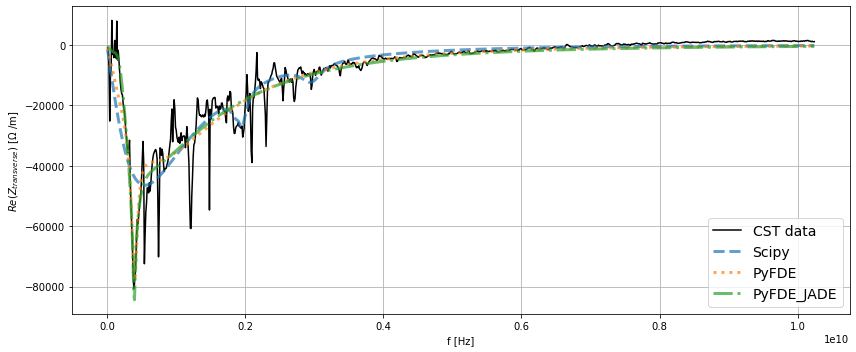

In [21]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.impedance_data.real, "black", label='CST data')

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.fitFunction(GA_model_scipy.frequency_data, dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)

ax0.plot(GA_model_pyfde.frequency_data, GA_model_pyfde.fitFunction(GA_model_pyfde.frequency_data, dict(enumerate(GA_model_pyfde.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle=':', label='PyFDE', alpha=0.7)

ax0.plot(GA_model_pyfde_jade.frequency_data, GA_model_pyfde_jade.fitFunction(GA_model_pyfde_jade.frequency_data, dict(enumerate(GA_model_pyfde_jade.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='-.', label='PyFDE_JADE', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{transverse})$ [$\Omega$ /m]')
ax0.legend(loc='best', fontsize=14)

ax0.grid()

fig.tight_layout()

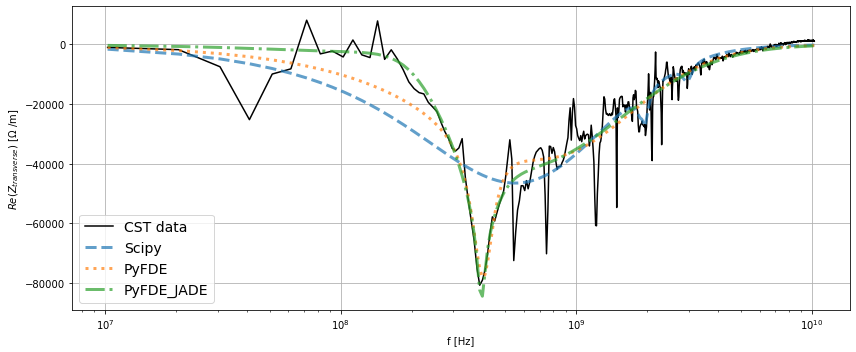

In [22]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.impedance_data.real, "black", label='CST data')

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.fitFunction(GA_model_scipy.frequency_data, dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)

ax0.plot(GA_model_pyfde.frequency_data, GA_model_pyfde.fitFunction(GA_model_pyfde.frequency_data, dict(enumerate(GA_model_pyfde.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle=':', label='PyFDE', alpha=0.7)

ax0.plot(GA_model_pyfde_jade.frequency_data, GA_model_pyfde_jade.fitFunction(GA_model_pyfde_jade.frequency_data, dict(enumerate(GA_model_pyfde_jade.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='-.', label='PyFDE_JADE', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{transverse})$ [$\Omega$ /m]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xscale('log')

ax0.grid()

fig.tight_layout()

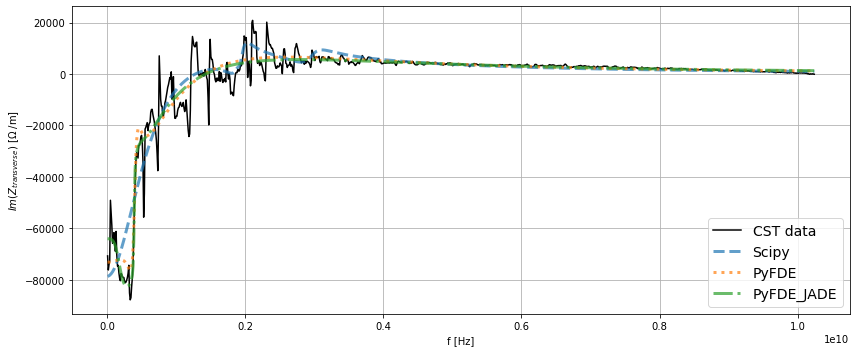

In [23]:
#Plot imaginary part of impedance

fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.impedance_data.imag, "black", label='CST data')

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.fitFunction(GA_model_scipy.frequency_data, dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3)))).imag,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)

ax0.plot(GA_model_pyfde.frequency_data, GA_model_pyfde.fitFunction(GA_model_pyfde.frequency_data, dict(enumerate(GA_model_pyfde.minimizationParameters.reshape(-1, 3)))).imag,
         lw = 3, linestyle=':', label='PyFDE', alpha=0.7)

ax0.plot(GA_model_pyfde_jade.frequency_data, GA_model_pyfde_jade.fitFunction(GA_model_pyfde_jade.frequency_data, dict(enumerate(GA_model_pyfde_jade.minimizationParameters.reshape(-1, 3)))).imag,
         lw = 3, linestyle='-.', label='PyFDE_JADE', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Im(Z_{transverse})$ [$\Omega$ /m]')
ax0.legend(loc='best', fontsize=14)

ax0.grid()

fig.tight_layout()

# Crosscheck with the wake
Here I load the CST wake and compare with the wake function reconstruction obtained from the fitted resonators parameters

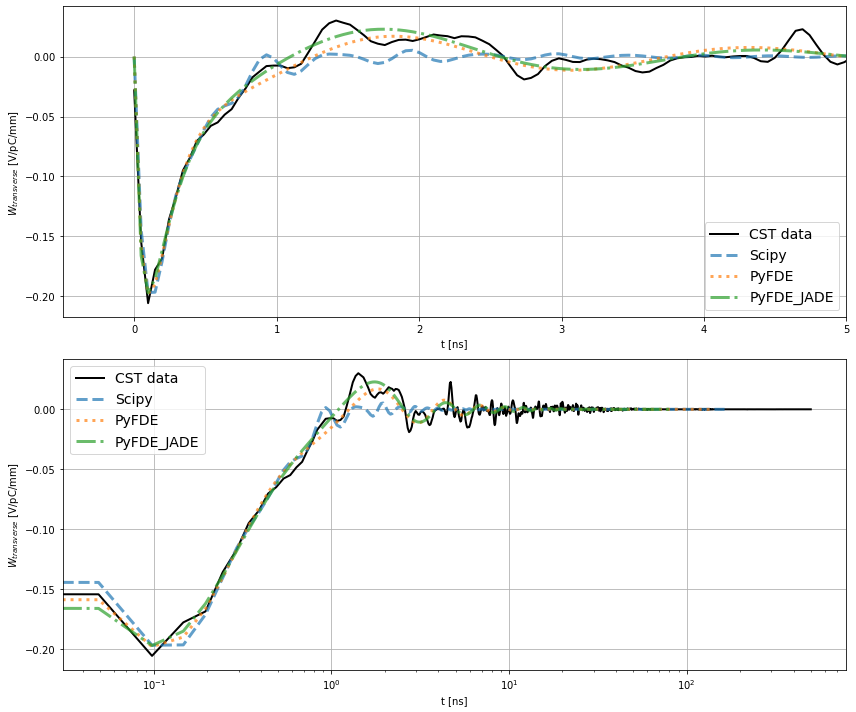

In [24]:
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(12,10))

ax0.plot(GA_model_scipy.time_data*1e9, GA_model_scipy.wake_data, "black", lw=2, label='CST data')

ax0.plot(GA_model_scipy.time_data*1e9, n_Resonator_transverse_wake(GA_model_scipy.time_data,
                                                                   dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3))))*1e-15,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)

ax0.plot(GA_model_pyfde.time_data*1e9, n_Resonator_transverse_wake(GA_model_scipy.time_data,
                                                                   dict(enumerate(GA_model_pyfde.minimizationParameters.reshape(-1, 3))))*1e-15,
         lw = 3, linestyle=':', label='PyFDE', alpha=0.7)

ax0.plot(GA_model_pyfde_jade.time_data*1e9, n_Resonator_transverse_wake(GA_model_pyfde_jade.time_data,
                                                                   dict(enumerate(GA_model_pyfde_jade.minimizationParameters.reshape(-1, 3))))*1e-15,
         lw = 3, linestyle='-.', label='PyFDE_JADE', alpha=0.7)

ax1.plot(GA_model_scipy.time_data*1e9, GA_model_scipy.wake_data, "black", lw=2, label='CST data')

ax1.plot(GA_model_scipy.time_data*1e9, n_Resonator_transverse_wake(GA_model_scipy.time_data,
                                                                   dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3))))*1e-15,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)

ax1.plot(GA_model_pyfde.time_data*1e9, n_Resonator_transverse_wake(GA_model_scipy.time_data,
                                                                   dict(enumerate(GA_model_pyfde.minimizationParameters.reshape(-1, 3))))*1e-15,
         lw = 3, linestyle=':', label='PyFDE', alpha=0.7)

ax1.plot(GA_model_pyfde_jade.time_data*1e9, n_Resonator_transverse_wake(GA_model_pyfde_jade.time_data,
                                                                   dict(enumerate(GA_model_pyfde_jade.minimizationParameters.reshape(-1, 3))))*1e-15,
         lw = 3, linestyle='-.', label='PyFDE_JADE', alpha=0.7)

ax1.set_xscale('log')

ax0.set_xlabel('t [ns]')
ax1.set_xlabel('t [ns]')

ax0.set_ylabel('$W_{transverse}$ [V/pC/mm]')
ax1.set_ylabel('$W_{transverse}$ [V/pC/mm]')

ax0.set_xlim(-0.5, 5)

ax0.legend(loc='best', fontsize=14)
ax1.legend(loc='best', fontsize=14)

ax0.grid()
ax1.grid()

fig.tight_layout()

# Test functions

In [25]:
%%time
# test alglib
def cost_function(pars):
    cost = sumOfSquaredError(pars, n_Resonator_transverse_imp, frequency_data, impedance_data)
    return cost

def stop_criterion(solver):
    '''
    Based on the criterion used in scipy.optimize.differential_evolution 
    (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html)
    Check that the ratio of the spread of the population fitness compared to its average.
    In other words, if most of the population individuals converge to the same solution indicating
    an optimal solution has been found.
    '''
    population_cost = np.vstack(solver)[:,1]
    population_mean, population_std = np.mean(population_cost), np.std(population_cost)
    criterion = population_std / np.abs(population_mean)
    return criterion

solver = pyfde.ClassicDE(cost_function, n_dim=3*Nres, n_pop=25*Nres, limits=parameterBounds, minimize=True)
solver.cr, solver.f = 0.8, 0.45

max_it = 3000
tol = 1e-2
i = 0
for i in range(max_it):
    sys.stdout.write('\r{}/{}'.format(i, max_it))
    best, _ = solver.run(n_it=1)
    progress_bar_gui(1, tol/stop_criterion(solver))
    if stop_criterion(solver) < tol:
        break
    else:
        continue
    
print('\n')
print(stop_criterion(solver))
print(best)

 Convergence to optimal solution : [--------------------] 1% 

<timed exec>:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


 Convergence to optimal solution : [####################] 100%


0.0093328552413592
[-7.00000000e+05  1.52203980e+01  1.05025684e+06 -2.87883334e+04
  3.68389138e-01  1.36724698e+09 -7.00000000e+05  1.96066715e+01
  4.30207436e+06  7.14163929e+04  7.30086209e+00  1.00000000e+03]
CPU times: user 3.39 s, sys: 94.8 ms, total: 3.48 s
Wall time: 3.44 s


In [26]:
%%time
# test alglib

solver_jade = pyfde.JADE(cost_function, n_dim=3*Nres, n_pop=25*Nres, limits=parameterBounds, minimize=True)

max_it = 1000
tol = 1e-2
i = 0
for i in range(max_it):
    sys.stdout.write('\r{}/{}'.format(i, max_it))
    best2, _ = solver_jade.run(n_it=1)
    progress_bar_gui(1, np.max((tol/stop_criterion(solver_jade), i/max_it)))
    if stop_criterion(solver_jade) < tol:
        break
    else:
        continue
    
print('\n')
print(stop_criterion(solver_jade))
print(best2)

 Convergence to optimal solution : [--------------------] 1% 

<timed exec>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


 Convergence to optimal solution : [####################] 100% 

0.17668143523891428
[-2.26365581e+04  7.85917047e+00  5.66926094e+08 -9.61140829e+03
  7.90299350e-01  1.09061479e+09 -5.05481890e+04  3.65156301e+00
  3.95107218e+08 -1.76211713e+04  4.40646364e-01  1.73836683e+09]
CPU times: user 33 s, sys: 970 ms, total: 34 s
Wall time: 33.6 s
